In [414]:
#!conda install -c conda-forge python-docx seaborn

Solving environment: done

# All requested packages already installed.



In [415]:
from model import ModelShaving
# from docplex.mp.advmodel import AdvModel
import numpy as np
import pandas as pd
import pickle

In [416]:
columns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [417]:
figure_size =[20,6]
save_dir = 'media'

In [418]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
invalid = '<>:"/\|?* '

In [419]:
filename = "ConsommationUniversite.pickle"
df = pd.read_pickle(filename)
print(df.shape)
year = df['year'].unique()
print(year)
print(df.columns)
print(max(df['Power [kW]']),max(df['Power Clipped [kW]']))

(69504, 15)
[2015 2016]
Index(['Timestamp', 'Power [kW]', 'year', 'month', 'day', 'hour', 'dayofyear', 'quarter', 'week', 'weekday', 'is_workday', 'year_month', 'month_week', 'Power Clipped [kW]', 'is_peak'], dtype='object')
12442.0 2442.0


In [420]:
df['t'] = df.index

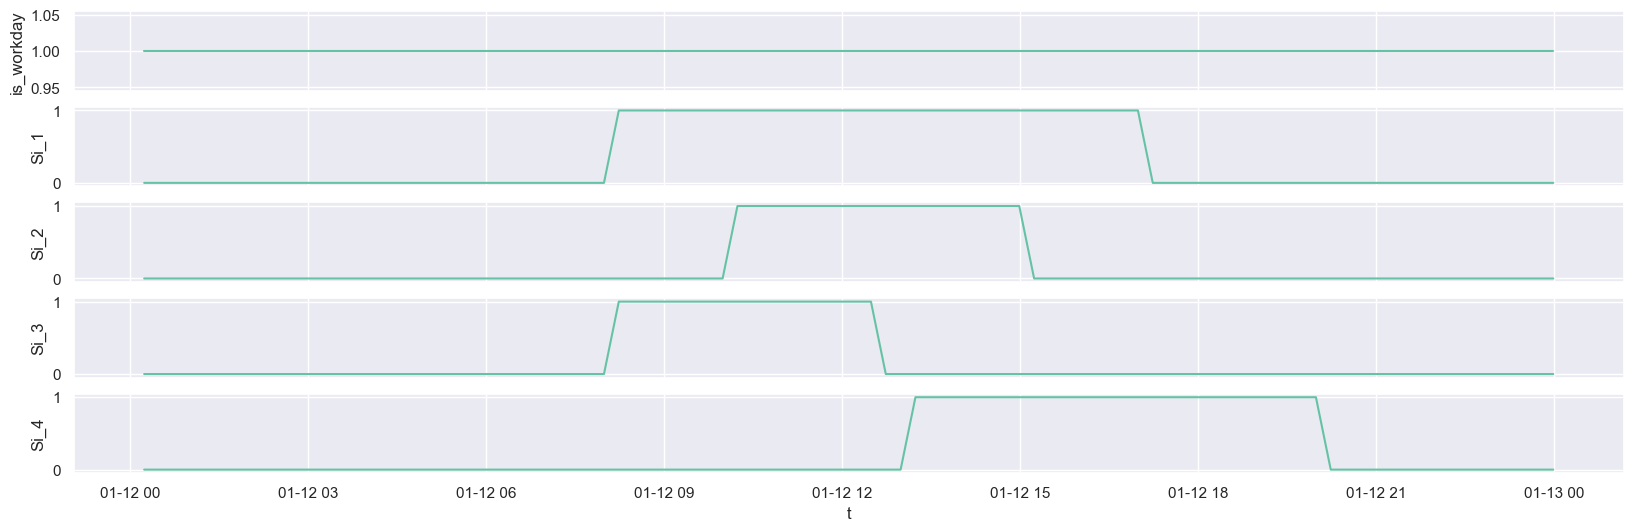

In [421]:
en = df[(df['dayofyear'] == 12) & (df['year'] == 2015)]

sig = generate_Si(df,
                 start=['08:00', '10:00', '08:00', '13:00'],
                 stop=['17:00', '15:00', '12:30', '20:00'],name='Si_')

en = pd.concat([en, sig], axis=1)

title = "Connections lors d'une journée"
what= 't'

sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=5, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y='is_workday', estimator='max', data=en,  ax=axs[0])
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[1])
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[2])
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[3])
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[4])
for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


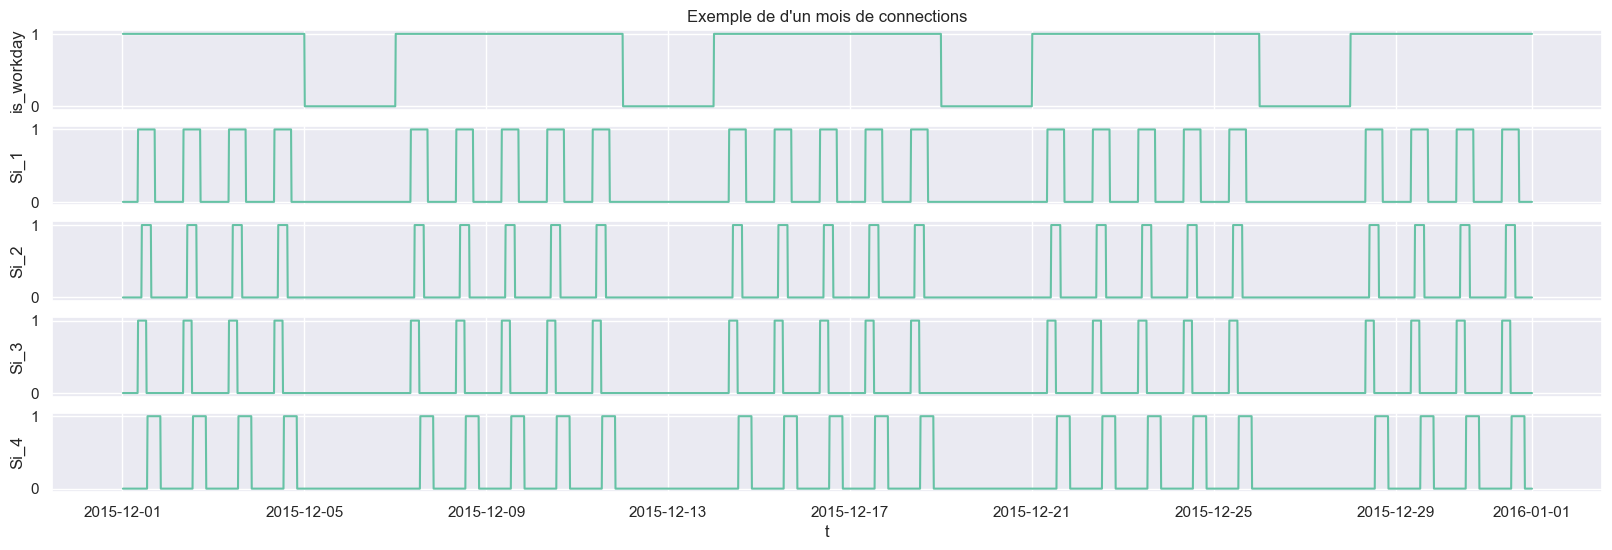

In [422]:
en = df[(df['month'] == 12) & (df['year'] == 2015)]

sig = generate_Si(df,
                 start=['08:00', '10:00', '08:00', '13:00'],
                 stop=['17:00', '15:00', '12:30', '20:00'],name='Si_')

en = pd.concat([en, sig], axis=1)

title = "Exemple de d'un mois de connections"
what= 't'

sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=5, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y='is_workday', estimator='max', data=en,  ax=axs[0])
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[1])
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[2])
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[3])
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[4])

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


In [423]:
def generate_Si(dataf, start, stop,name):
    d = pd.DataFrame(index=dataf.index)
    for i, (b, e) in enumerate(zip(start,stop)):
        ts = dataf.between_time(b, e)
        n = name+str(i+1)
        #try:
        d.loc[dataf.index,n] = 0

        #except:
        #    pass
        d.loc[ts.index,n] = np.where((ts['is_workday'] ==1), 1, 0)
    return d.copy(True)

In [424]:
#an = df[df['year'] == year[0]]
Si_gen = generate_Si(df,
                 start=['08:00', '10:00', '08:00', '13:00'],
                 stop=['17:00', '15:00', '12:30', '20:00'],name='Si_')#.to_numpy(copy=True)
an = pd.concat([df, Si_gen], axis=1)
#an = an[(an['week'] == 3) & (an['year'] == 2015)]

Pb = an['Power Clipped [kW]'].loc['2015-01-12':'2015-01-13']
idx = Pb.index
Pb = Pb.to_numpy(copy=True)
Si = Si_gen.loc['2015-01-12':'2015-01-13']
Si = Si.astype(float).to_numpy(copy=True)

print(Pb.shape, Si.shape)

#Pb = Pb[0:40]# 40
#idx = an.index[0:40]

l = Pb.shape[0]
print("maximum de Pb(t) clipped :{m} avec T={t}".format(m=max(Pb), t=l))
#Si = 10 * np.random.random_sample((l, 4)) - 5
#Si = np.random.randint(0, 2, size=(l, 1))
#Si = np.ones((l, 4))
print(np.amax(Si,axis=0))
print(Si_gen.max(axis=0))

(192,) (192, 4)
maximum de Pb(t) clipped :860.0 avec T=192
[1. 1. 1. 1.]
Si_1    1.0
Si_2    1.0
Si_3    1.0
Si_4    1.0
dtype: float64


In [425]:
print('Set problem parameters')
n_ev = 1000.0
# Prius 4.4kWh, Leaf 24kWh
soc_max = 0.8*24*1000
soc_min = 0.2*4.4*1000
print("{mi} <= SOC <= {ma}".format(mi=soc_min, ma=soc_max))

bn = n_ev
params = {
    # Variables	Descriptions	Unités
    'Ce': 0.06319, # $/kWh (tarif D)
    # Cout depassement: kWh/j

    'SOCmin': soc_min,  # État de charge minimum des véhicules électriques	kWh
    'SOCmax': soc_max,  # État de charge maximum des véhicules électriques	kWh
    'Pch_min': 0*(4.4*(15/60))*bn,  # Puissance de charge minimum 	kW
    'Pdis_min': 0*(4.4*(15/60))*bn,  # Puissance de décharge minimum	kW
    'Pch_max_n': [bn*7.5, bn*50.0],  # Puissance de charge maximum en utilisant les bornes de type n	kW
    'Pdis_max_n': [bn*5.0, bn*40.0],  # Puissance de décharge maximum en utilisant les bornes de type n	kW
    #'Pch_max_n': [50.0],  # Puissance de charge maximum en utilisant les bornes de type n	kW
    #'Pdis_max_n': [40.0],  # Puissance de décharge maximum en utilisant les bornes de type n	kW

    'beta_ch': 0.93,  # Efficacité de charge	%
    'beta_dis': 0.90,  # Efficacité de décharge	%
    'NEVs': n_ev,  # Nombre de véhicules électriques	Qté
    'Rut': [0.42, 0.38, 0.19, 0.11],  # Ratio d’utilisateurs avec le profil i	%
    #'Rut': [1.0],  # Ratio d’utilisateurs avec le profil i	%

    'delta_t': 15 / 60,  # 15mins
    'MAX_OPTIM': 1e8,  # Facteur majorant du programme d'optimisation

    'Pb': Pb,  # Puissance appelée par le bâtiment appelée à l’instant t	kW

    'Si': Si,#1, Si le profil d’utilisateur est raccordé à une borne à l’instant t

}

Set problem parameters
880.0000000000001 <= SOC <= 19200.000000000004


In [426]:
#more: https://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.solution.html#docplex.mp.solution.SolveSolution
mdl = ModelShaving('V2B', params=params)
mdl.problem_variables()
mdl.problem_constraints()
mdl.minimize(mdl.problem_cout_depassement())
mdl.add_kpi(mdl.min(mdl.problem_cout_depassement()), "Min Cout dépassement")

print('\n')
mdl.print_information()
solus = mdl.solve()
assert solus, "!!! Solve of the model fails"
print("********************************************")
print("Obj", mdl.solution.get_objective_value())
mdl.print_solution(print_zeros=False)
print("--------------------------------------------")
mdl.report()
print("--------------------------------------------")
print('end')
with open('solution.pickle', mode='wb') as f:
    pickle.dump(solus, f)
filename = Path(save_dir,'solution.json')
with open('solution.pickle', mode='wb') as f:
    solus.export(f,format='json')



Model: V2B
 - number of variables: 9800
   - binary=1544, integer=0, continuous=8256
 - number of constraints: 12088
   - linear=12088
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
********************************************
Obj 2184.5
objective: 2184.500
status: OPTIMAL_SOLUTION(2)
  SOC__1_1_0=19200.000
  SOC__1_1_1=19200.000
  SOC__1_1_2=19200.000
  SOC__1_1_3=19200.000
  SOC__1_1_4=19200.000
  SOC__1_1_5=19200.000
  SOC__1_1_6=19200.000
  SOC__1_1_7=19200.000
  SOC__1_1_8=19200.000
  SOC__1_1_9=19200.000
  SOC__1_1_10=19200.000
  SOC__1_1_11=19200.000
  SOC__1_1_12=19200.000
  SOC__1_1_13=19200.000
  SOC__1_1_14=19200.000
  SOC__1_1_15=19200.000
  SOC__1_1_16=19200.000
  SOC__1_1_17=19200.000
  SOC__1_1_18=19200.000
  SOC__1_1_19=19200.000
  SOC__1_1_20=19200.000
  SOC__1_1_21=19200.000
  SOC__1_1_22=19200.000
  SOC__1_1_23=19200.000
  SOC__1_1_24=19200.000
  SOC__1_1_25=19200.000
  SOC__1_1_26=19200.000
  SOC__1_1_27=19200.000
  SOC__1_1_28=19200.000
 

In [427]:
dk = pd.DataFrame({'Pb batiment': mdl.params['Pb'],
                   'Pr reseau': solus.get_value_list(mdl.Pr__t),
                   'P charge totale': solus.get_value_list(mdl.Pch_tot__t),
                   'P décharge totale': solus.get_value_list(mdl.Pdis_tot__t),
                   #'t':idx
                   #'Si group 1': mdl.params['Si'][:, 0],
                   #'Si group 2': mdl.params['Si'][:, 1],
                   #'Si group 3': mdl.params['Si'][:, 2],
                   #'Si group 4': mdl.params['Si'][:, 3]
                   }
                  ).set_index(idx)

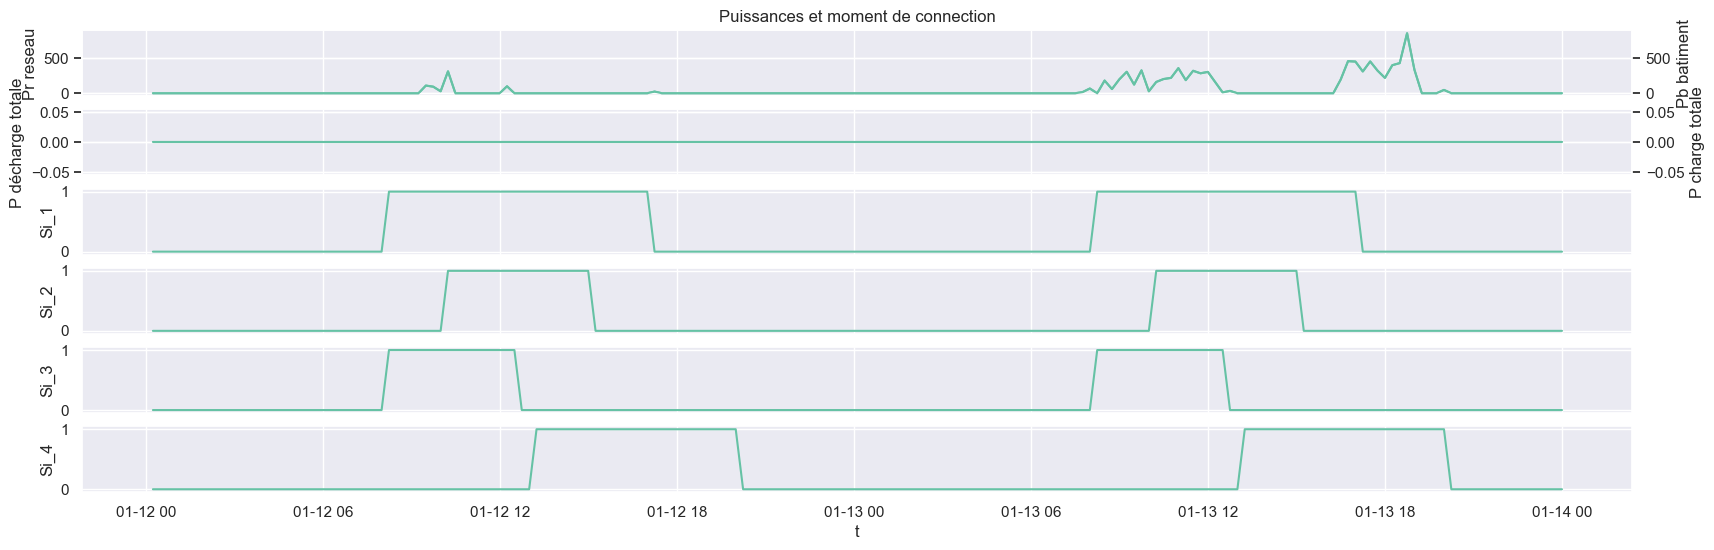

In [428]:
title = 'Puissances et moment de connection'
en = pd.DataFrame(mdl.params['Si'], columns=['Si_1', 'Si_2','Si_3','Si_4'])
en['t'] = idx
fig, axs = plt.subplots(nrows=6, figsize=figure_size, sharex=True)
g = sns.lineplot(x=dk.index, y='Pr reseau', estimator='max', data=dk,  ax=axs[0])
ax2 = g.twinx()
h = sns.lineplot(x=dk.index, y='Pb batiment', estimator='max', data=dk, ax=ax2)
g = sns.lineplot(x=dk.index, y='P décharge totale', estimator='max', data=dk,  ax=axs[1])
ax2 = g.twinx()
h = sns.lineplot(x=dk.index, y='P charge totale', estimator='max', data=dk, ax=ax2)
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[2])
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[3])
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[4])
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[5])

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


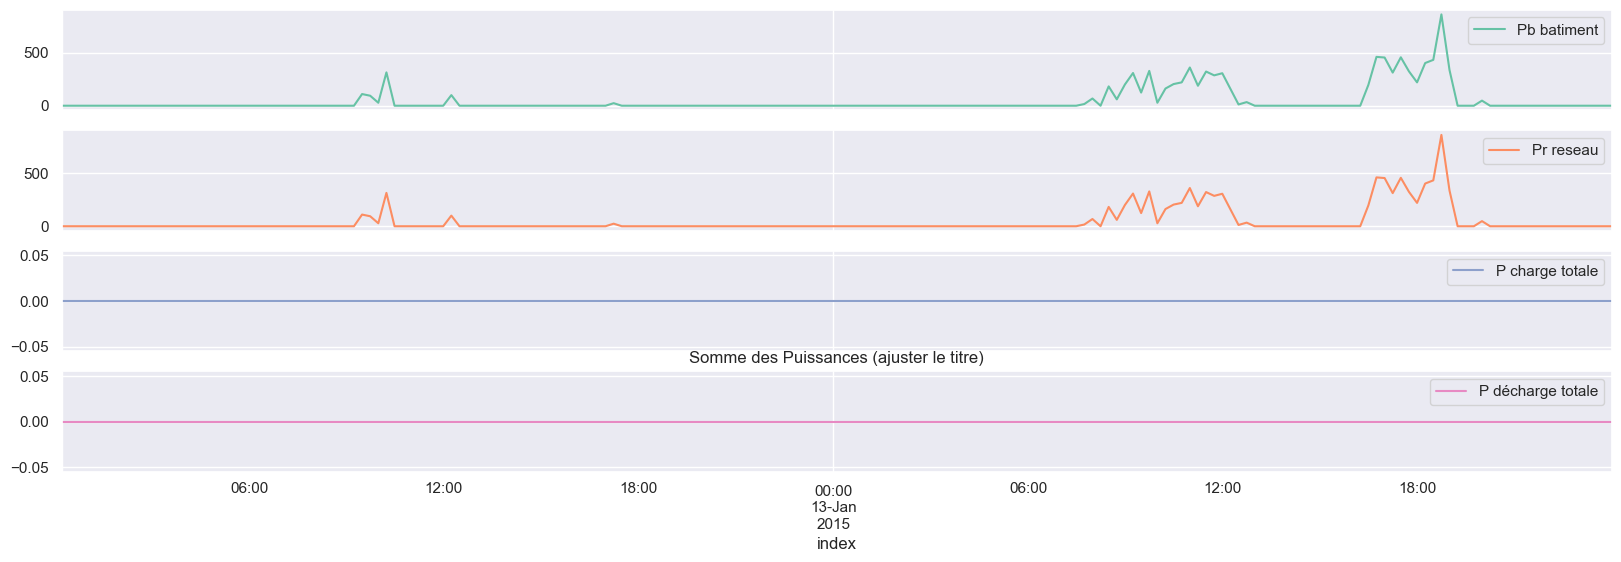

In [429]:
title = "Somme des Puissances (ajuster le titre)"
dk.plot(figsize=figure_size,subplots=True)
for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)
plt.title(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


In [430]:
df_Pch__i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch_demand_i_t,
                                 index='t', columns='i', prefix='Pch__i_t__')
#print(df_Pch__i_t)
df_Pdis__i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch_demand_i_t,
                                 index='t', columns='i', prefix='Pdis__i_t__')
#print(df_Pdis__i_t)

df_Rborne__n_i = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Rborne__n_i,
                                 index='i', columns='n')
print(df_Rborne__n_i)

df_SOC__n_i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.SOC__n_i_t, index='t', columns=['n', 'i'])
#df_SOC__n_i_t.rename(mapper=lambda x: f'N_{x}', axis='columns', level=0, inplace=True)
#df_SOC__n_i_t.rename(mapper=lambda x: f'I_{x}', axis='columns', level=1, inplace=True)
#print(df_SOC__n_i_t)


n  1  2
i      
1  0  0
2  0  0
3  0  0
4  0  0


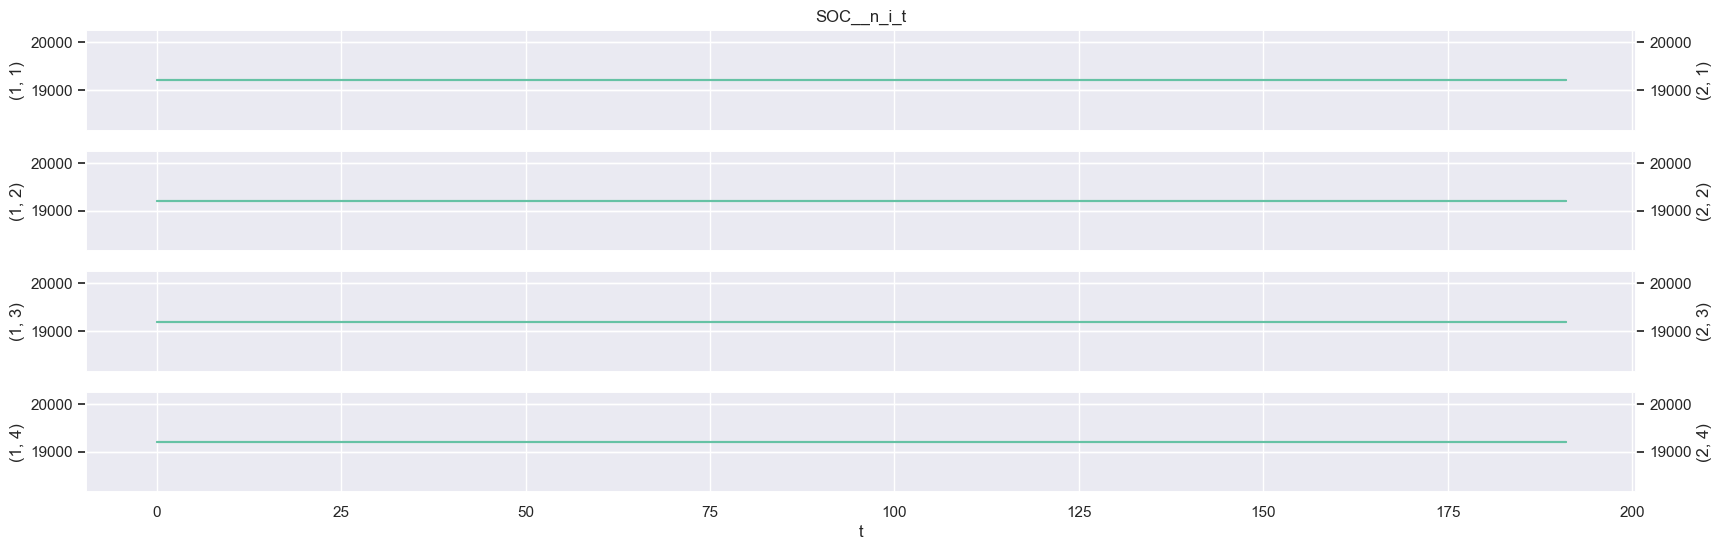

In [431]:
# Error Bands + valeur maximale des mois

title = "SOC__n_i_t"

what= 't'

#sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=4, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y=(1,1), estimator='max', data=df_SOC__n_i_t,  ax=axs[0])
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,1), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g = sns.lineplot(x=what, y=(1,2), estimator='max', data=df_SOC__n_i_t, ax=axs[1])
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,2), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g = sns.lineplot(x=what, y=(1,3), estimator='max', data=df_SOC__n_i_t, ax=axs[2])
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,3), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g = sns.lineplot(x=what, y=(1,4), estimator='max', data=df_SOC__n_i_t, ax=axs[3])
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,4), estimator='max', data=df_SOC__n_i_t, ax=ax2)


for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


In [437]:
import docx
from docx import Document

doc = Document()
doc.add_heading('Résumé des informations du problème', 0)

doc.add_paragraph('Rborne[n,i]')
t_df = df_Rborne__n_i

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(t_df.shape[0]+1, t_df.shape[1])
#t.style = 'LightShading-Accent1'
# add the header rows.
for j in range(t_df.shape[-1]):
    t.cell(0,j).text = str(t_df.columns[j])
# add the rest of the data frame
for i in range(t_df.shape[0]):
    print(i)
    r = t_df.index[i]
    for j in range(t_df.shape[-1]):
        t.cell(i+1,j).text = str(t_df.values[i,j])

# save the doc
doc.save(Path(save_dir, 'tables.docx'))

0 1
1 2
2 3
3 4
